In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
from qiskit import *
import time
import mapomatic as mm
from qiskit_ibm_runtime.fake_provider import FakeBelemV2, FakeManilaV2
from qiskit.circuit.library import *
from qiskit.visualization import plot_error_map, plot_circuit_layout


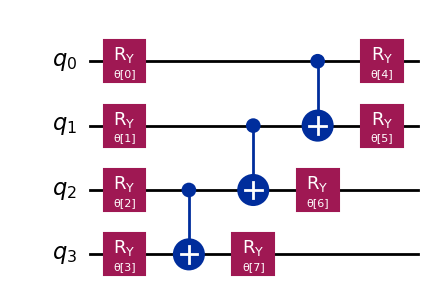

In [12]:
num_qubits=4
circ_test = RealAmplitudes(num_qubits, reps=1) 
circ_test = circ_test.decompose()

circ_test.remove_final_measurements(inplace=True)
circ_test.draw('mpl')

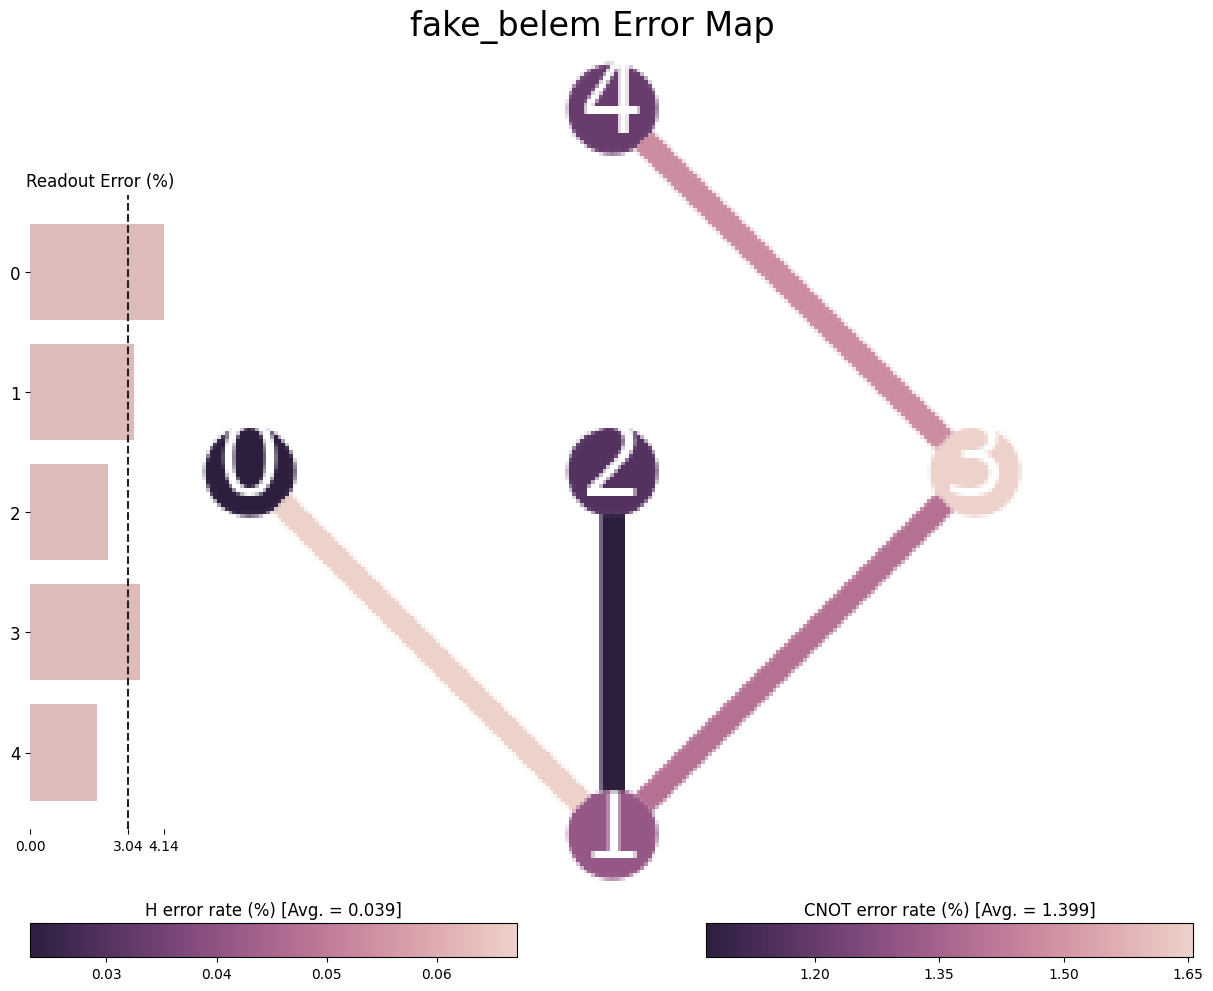

In [13]:
backend = FakeBelemV2()
plot_error_map(backend)

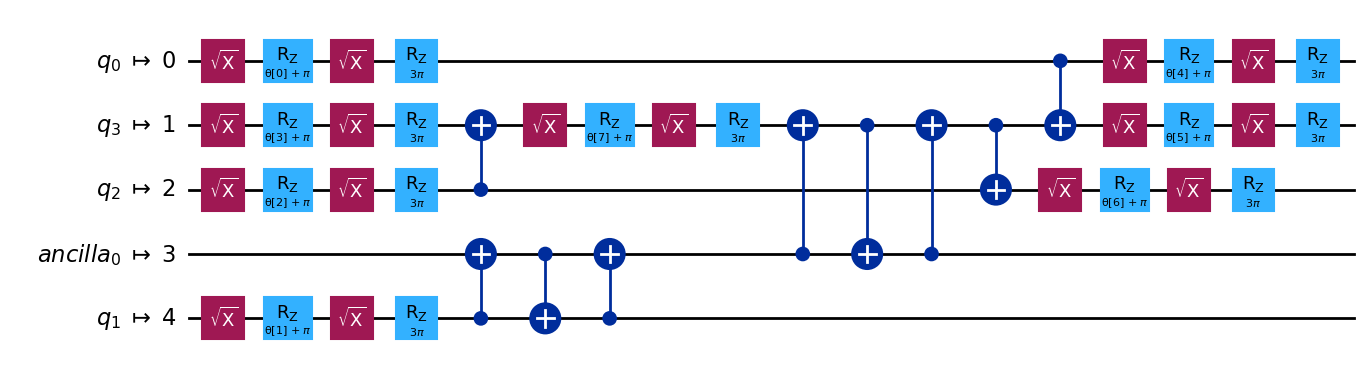

In [20]:
test_graph_layout = [0, 4, 2,1]
transpiled_circ = transpile(circ_test, backend=backend, initial_layout=test_graph_layout)
transpiled_circ.draw('mpl')

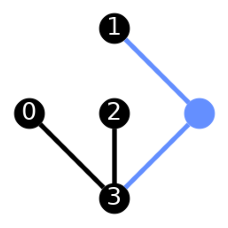

In [21]:
plot_circuit_layout(transpiled_circ, backend=backend)